In [1]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append("../../code/data_processing/name_resolution/")
from resolved_names_curator import ResolvedNamesCurator

import matplotlib.pyplot as plt
from ete3 import Tree

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
polyploidy_threshold = 0.75
diploidy_threshold = 0.25

ploidb_path = f"/groups/itay_mayrose/halabikeren/PloiDB/chromevol/database/ploidb_by_genus_without_missing.csv"
qdb_path = "/groups/itay_mayrose/halabikeren/PloiDB/chromevol/results/cvalues_db.csv"

unresolved_plant_names_path = f"../../data/name_resolution/unresolved_plant_names.csv"
resolved_plant_names_path = f"../../data/name_resolution/plant_nr_rwfo/processed_resolved_plant_names.csv"
resolved_pollinator_names_path = f"../../data/name_resolution/resolved_pollinator_names.csv"

tree_path = "../../data/trees/ALLMB.tre"
ccdb_path = "/groups/itay_mayrose/halabikeren/PloiDB/ccdb/all_data_with_ALLMB_mapped_names.csv"
classification_data_path = "/groups/itay_mayrose/halabikeren/PloiDB/trees/wfo_classification_data.csv"
missing_names_path = "/groups/itay_mayrose/halabikeren/PloiDB/trees/names_to_add_for_ppn_project.csv"

networks_types = ["weighted", "binary", "binarized_weighted"]
all_networks_dir = "/groups/itay_mayrose/halabikeren/plant_pollinator_networks/networks/all/"

plant_classification_path = f"../../data/ploidy_classification/plant_classification.csv"
network_classification_path = f"../../data/ploidy_classification/network_classification.csv"

all_networks_dir = "../../data/networks/all/"
networks_metadata_path = f"../../data/networks/networks_metadata.csv"

# Examine coverage in kew-DB

In [ ]:
kew_db = pd.read_csv(qdb_path)
resolved_names = pd.read_csv(resolved_plant_names_path)

In [ ]:
kew_db["taxon"] = (kew_db["Genus"] + " " + kew_db["Species"] + kew_db["Subspecies"].replace({np.nan: ""})).str.lower()

In [ ]:
kew_db["is_polyploid"] = kew_db["Ploidy Level (x)"].apply(lambda l: np.nan if l == "-" else int(int(l) > 2))
kew_db = kew_db.dropna(subset=["is_polyploid"]).drop_duplicates(subset=["taxon"])
kew_db.shape[0]

In [ ]:
kew_based_classification = resolved_names
kew_based_classification["is_polyploid"] = np.nan
kew_based_classification.set_index("resolved_name", inplace=True)
kew_based_classification["is_polyploid"].fillna(value=kew_db.set_index("taxon")["is_polyploid"].to_dict(), inplace=True)
kew_based_classification.reset_index(inplace=True)
kew_based_classification.set_index("original_name", inplace=True)                                                
kew_based_classification["is_polyploid"].fillna(value=kew_db.set_index("taxon")["is_polyploid"].to_dict(), inplace=True)
kew_db.reset_index(inplace=True)
kew_based_classification.reset_index(inplace=True)

In [ ]:
kew_based_classification = kew_based_classification.drop_duplicates(subset=["original_name"])

In [ ]:
kew_based_classification.notna().sum()

In [ ]:
kew_based_classification.notna().sum() / kew_based_classification.shape[0] * 100

In [10]:
len(set(kew_db.set_index("taxon")["is_polyploid"].to_dict().keys()) & set(resolved_names.original_name))

399

In [11]:
len(set(kew_db.set_index("taxon")["is_polyploid"].to_dict().keys()) & set(resolved_names.resolved_name))

369

# Extract classification at plant species level

In [11]:
plant_classification_df = pd.read_csv(resolved_plant_names_path)[["original_name","matched_name", "resolved_name", "ploidb_name"]]
for c in plant_classification_df.columns:
    plant_classification_df[c] = plant_classification_df[c].str.lower()

ploidy_df = pd.read_csv(ploidb_path)
ploidy_df["Ploidy inference"] = ploidy_df["Ploidy transitions frequency"].apply(lambda f: 1 if f >= polyploidy_threshold else (0 if f < diploidy_threshold else np.nan))

plant_classification_df = plant_classification_df.merge(ploidy_df[["Taxon", "Genus", "Family", "Ploidy inference", "Ploidy age"]], left_on="ploidb_name", right_on="Taxon", how="left")
plant_classification_df = plant_classification_df.rename(columns={"Ploidy inference": "is_polyploid", "Ploidy age": "polyploid_age"}).drop(["Taxon"], axis=1)
plant_classification_df.to_csv(plant_classification_path, index=False)

In [12]:
print(f"% classified = {np.round(plant_classification_df.dropna(subset=['is_polyploid']).shape[0]/plant_classification_df.shape[0]*100, 2)}% ({plant_classification_df.dropna(subset=['is_polyploid']).shape[0]:,})")

% classified = 41.63% (2,227)


<AxesSubplot: >

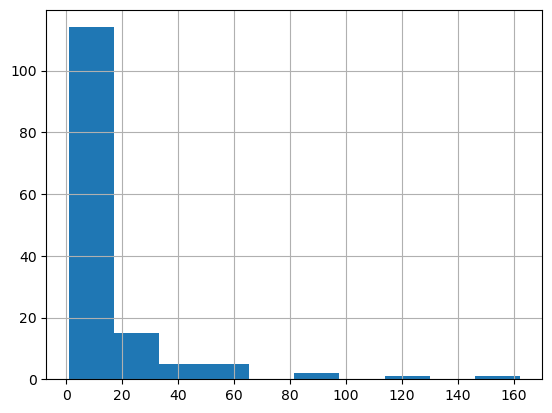

In [25]:
family_to_classified = plant_classification_df.dropna(subset=["is_polyploid"]).groupby("Family").ploidb_name.count().sort_values(ascending=False)
family_to_classified[family_to_classified < 200].hist()

In [5]:
missing_names = plant_classification_df.loc[plant_classification_df.is_polyploid.isna()].ploidb_name.drop_duplicates().dropna().tolist()
avail_names = plant_classification_df.loc[plant_classification_df.is_polyploid.notna()].ploidb_name.drop_duplicates().dropna().tolist()

# assign ploidy ages to diploid taxa

In [6]:
plant_classification = pd.read_csv(plant_classification_path)

In [15]:
plant_classification.loc[(plant_classification.ploidb_name != plant_classification.resolved_name) & (plant_classification.ploidb_name != plant_classification.original_name)].dropna(subset=["is_polyploid"])

,ploidb_name,original_name,matched_name,resolved_name,is_polyploid,polyploid_age
42,sinningia verticillata,sinningia douglasii,NaN,sinningia douglasii,0.0,9.198317
113,tillandsia venusta,tillandsia gardneri,NaN,tillandsia gardneri,0.0,103.854830
365,wedelia fruticosa,wedelia calycina,NaN,wedelia calycina,0.0,2.035702
399,passiflora foetida,passiflora foetida l.,passiflora foetida var. arida,passiflora arida,1.0,6.277480
468,diospyros glaucifolia,diospyrus japonica,NaN,diospyros japonica,0.0,94.772475
...,...,...,...,...,...,...
5213,cordia polycephala,cordia corymbosa,cordia corymbosa,varronia polycephala,0.0,74.715914
5216,vitex trifolia subsp. litoralis,vitex rotundifolia,vitex rotundifolia,NaN,0.0,2.627097
5261,filipendula glaberrima,filipendula multifuga,NaN,filipendula multijuga,0.0,124.405486
5278,cornus kousa subsp. chinensis,benthamidia japonica,benthamidia japonica,cornus kousa,0.0,101.023554


In [9]:
diploids_for_age_classification = plant_classification.query("polyploid_age.isna() and is_polyploid.notna()")
print(f"# diploids for which ploidy age classification is required = {diploids_for_age_classification.shape[0]:,}")

# diploids for which ploidy age classification is required = 1


<AxesSubplot: >

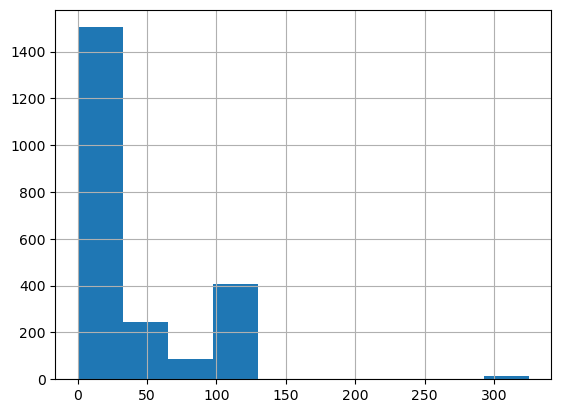

In [10]:
plant_classification.polyploid_age.hist()

# report ploidy classification stats

In [11]:
print(f"% polyploids = {np.round(plant_classification.loc[plant_classification.is_polyploid == 1].shape[0]/plant_classification.shape[0]*100,2)}% ({plant_classification.loc[plant_classification.is_polyploid == 1].shape[0]:,})")
print(f"% diploids = {np.round(plant_classification.loc[plant_classification.is_polyploid == 0].shape[0]/plant_classification.shape[0]*100,2)}% ({plant_classification.loc[plant_classification.is_polyploid == 0].shape[0]:,})")
print(f"% undetermined = {np.round(plant_classification.loc[plant_classification.is_polyploid.isna()].shape[0]/plant_classification.shape[0]*100,2)}% ({plant_classification.loc[plant_classification.is_polyploid.isna()].shape[0]:,})")

% polyploids = 15.37% (822)
% diploids = 26.27% (1,405)
% undetermined = 58.37% (3,122)


In [16]:
species_names_dfs = []
for networks_type in networks_types:
    networks_dir = f"../../data/networks/all/{networks_type}/"
    for path in os.listdir(networks_dir):
        if path.endswith(".csv"):
            try:
                network_path = f"{networks_dir}{path}"
                network = pd.read_csv(network_path)
                if not "Plant" in network.columns:
                    network = network.rename(columns={"Unnamed: 0": "Plant"})
                    network.to_csv(network_path)
                network_species = pd.DataFrame(columns=["network_type", "network_id", "original_name"])
                network_species["original_name"] = network.Plant.tolist()
                network_species["network_type"] = networks_type
                network_species["network_id"] = int(path.replace(".csv", ""))
                species_names_dfs.append(network_species)
            except Exception as e:
                print(f"error {e} for {path}")
                continue
features_by_network = pd.concat(species_names_dfs)
features_by_network.original_name = features_by_network.original_name.str.lower()
features_by_network.original_name = features_by_network.original_name.apply(lambda name: name.replace("_", " "))
features_by_network = features_by_network.merge(plant_classification_df[["original_name", "is_polyploid", "polyploid_age"]], on="original_name", how="left")

In [17]:
def get_poly_frac(labels):
    poly = (labels == 1).sum()
    di = (labels == 0).sum()
    return poly/(di+poly)

def get_missing_frac(labels):
    missing = (labels.isna()).sum()
    return missing/len(labels)         

network_classification = features_by_network.groupby(["network_type", "network_id"]).agg({"is_polyploid": [get_poly_frac, get_missing_frac]}).reset_index()
network_classification.columns = [f"{c[0]}{c[1].replace('get','')}" for c in network_classification.columns]

network_classification = network_classification.fillna(0)

/tmp/ipykernel_35324/2653682608.py:4: RuntimeWarning: invalid value encountered in long_scalars
  return poly/(di+poly)


In [18]:
network_classification.to_csv(network_classification_path, index=False)

# fill network coverage as metadata

In [19]:
network_classification = pd.read_csv(network_classification_path)
plant_classification = pd.read_csv(plant_classification_path)

In [20]:
def get_network_stats(rec: pd.Series) -> list:
    network_path = f"{all_networks_dir}{rec.network_type}/{rec.network_id}.csv"
    network = pd.read_csv(network_path)
    plants = network.Plant.str.lower().unique().tolist()
    n_plants = len(plants)
    n_resolved = len(plant_classification.loc[(plant_classification.original_name.isin(plants)) & (plant_classification.resolved_name.notna())].original_name.unique())
    n_classified = len(plant_classification.loc[(plant_classification.original_name.isin(plants)) & (plant_classification.is_polyploid.notna())].original_name.unique())
    n_polyploids = len(plant_classification.loc[(plant_classification.original_name.isin(plants)) & (plant_classification.is_polyploid == 1)].original_name.unique())
    n_diploids = len(plant_classification.loc[(plant_classification.original_name.isin(plants)) & (plant_classification.is_polyploid == 0)].original_name.unique())
    return n_plants, n_resolved, n_classified, n_polyploids, n_diploids

network_classification[["num_plants", "num_resolved", "num_classified", "num_polyploids", "num_diploids"]] = network_classification.parallel_apply(get_network_stats, axis=1, result_type="expand")

In [21]:
network_classification = network_classification.rename(columns={"network_id": "network_index"})
network_classification.to_csv(network_classification_path)

In [22]:
print(f"% polyploids = {np.round(plant_classification.loc[plant_classification.is_polyploid == 1].shape[0] / plant_classification.loc[plant_classification.is_polyploid.notna()].shape[0]*100,2)}% ({plant_classification.loc[plant_classification.is_polyploid == 1].shape[0]})")
print(f"% diploids = {np.round(plant_classification.loc[plant_classification.is_polyploid == 0].shape[0] / plant_classification.loc[plant_classification.is_polyploid.notna()].shape[0]*100,2)}% ({plant_classification.loc[plant_classification.is_polyploid == 0].shape[0]})")

% polyploids = 36.91% (822)
% diploids = 63.09% (1405)


In [23]:
print(f"mean % of polyploids across networks = {np.round(network_classification.is_polyploid_poly_frac.mean()*100,2)}%")

mean % of polyploids across networks = 43.58%


<AxesSubplot: >

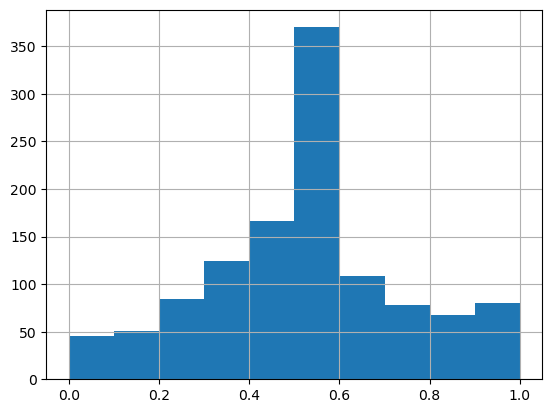

In [24]:
network_classification.loc[network_classification.is_polyploid_missing_frac <= 0.5].is_polyploid_poly_frac.hist()

In [25]:
networks_metadata = pd.read_csv(networks_metadata_path)
network_classification = pd.read_csv(network_classification_path)
networks_metadata = networks_metadata[[c for c in networks_metadata.columns if c not in ['is_polyploid_missing_frac', 'is_polyploid_poly_frac', 'num_classified']]]
networks_metadata = networks_metadata.merge(network_classification, on=["network_type", "network_index"], how="left")
networks_metadata.to_csv(networks_metadata_path, index=False)

/tmp/ipykernel_35324/2271092960.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  networks_metadata = networks_metadata.merge(network_classification, on=["network_type", "network_index"], how="left")


In [26]:
networks_metadata = networks_metadata.drop(["num_plants_x","num_resolved_x", "num_polyploids_x", "num_diploids_x"], axis=1).rename(columns={c: c.replace("_y", "") for c in networks_metadata.columns if c.endswith("_y")})
networks_metadata.filter(like="num")

,num_pollinators,num_plants.1,num_resolved.1,num_polyploids.1,num_diploids.1,num_plants,num_resolved,num_classified,num_polyploids,num_diploids
0,11,8,8,0,1,8,8,2,0,2
1,25,51,43,7,16,51,43,17,3,14
2,77,15,0,0,0,15,0,0,0,0
3,96,68,0,0,0,68,0,0,0,0
4,23,14,0,0,0,14,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1625,17,5,5,0,1,5,5,0,0,0
1626,14,6,6,0,2,6,6,1,0,1
1627,18,8,8,2,2,8,8,2,1,1
1628,12,5,5,0,1,5,5,0,0,0


In [27]:
networks_metadata["included_in_analysis"] = networks_metadata.apply(lambda rec: rec.num_classified >= 5 and
                                                                    rec.num_pollinators >= 5 and
                                                                    rec.is_polyploid_missing_frac <= 0.5 and
                                                                    pd.notna(rec.AnnualPrecipitation) and
                                                                    pd.notna(rec.frac_sc), axis=1)
networks_metadata.to_csv(networks_metadata_path, index=False)

Text(0.5, 1.0, 'distribution of %PP across 775 included in the analysis')

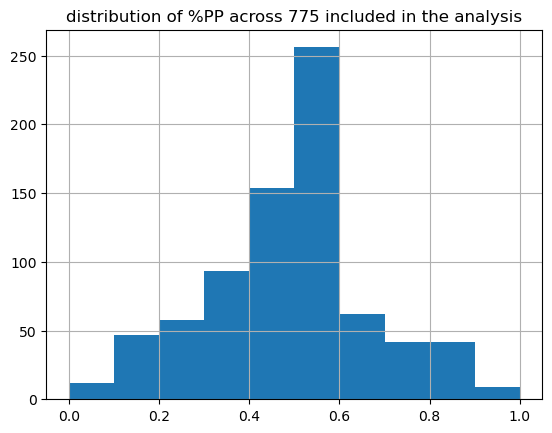

In [28]:
networks_metadata.loc[(networks_metadata.included_in_analysis)].is_polyploid_poly_frac.hist()
plt.title(f"distribution of %PP across {networks_metadata.loc[networks_metadata.included_in_analysis].shape[0]:,} included in the analysis")